# LBRAT2104 - Data Manipulations

- Author : Nicolas Deffense
- Year : 2020-2021

## Import packages & check version

In [2]:
import glob, os
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import rasterio.mask
from rasterio.enums import Resampling
from rasterio import plot
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import rasterstats
from rasterstats import zonal_stats
import scipy

print(f'Numpy : {np.__version__}')
print(f'Pandas : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')
print(f'Rasterio : {rasterio.__version__}')
print(f'Rasterstats : {rasterstats.__version__}')
print(f'Matplotlib : {matplotlib.__version__}')
print(f'Scipy : {scipy.__version__}')


Numpy : 1.19.2
Pandas : 1.1.5
GeoPandas : 0.8.1
Rasterio : 1.1.0
Rasterstats : 0.14.0
Matplotlib : 3.3.2
Scipy : 1.5.2


In [2]:
# Improving plot image quality and resolution

%config InlineBackend.figure_format = 'retina'

## Set paths
- Where are stored your data ?
- Where do you want to store the data you will create ?

In [3]:
# Change with your group letter and your name

grp_letter   = 'X'
student_name = 'ndeffense'

# Directory "data" are read-only for students - you cannot write inside !

input_path  = 'X:/data/'

raster_path = f'{input_path}RASTER/'
vector_path = f'{input_path}VECTOR/'


# Create a directory to store your data from TP

output_path = f'X:/GROUP_{grp_letter}/TP/{student_name}/DATA/'



Directory already exists !


## Clip raster using a shapefile

Width ori  : 5490
Height ori : 5490
----------------------
Width clipped  : 493
Height clipped : 285
----------------------
A new raster file is created : X:/GROUP_X/TP/ndeffense/DATA/CLIP_TP1/T31UFS_20200731T103629_SCL_20m_ROI.tif


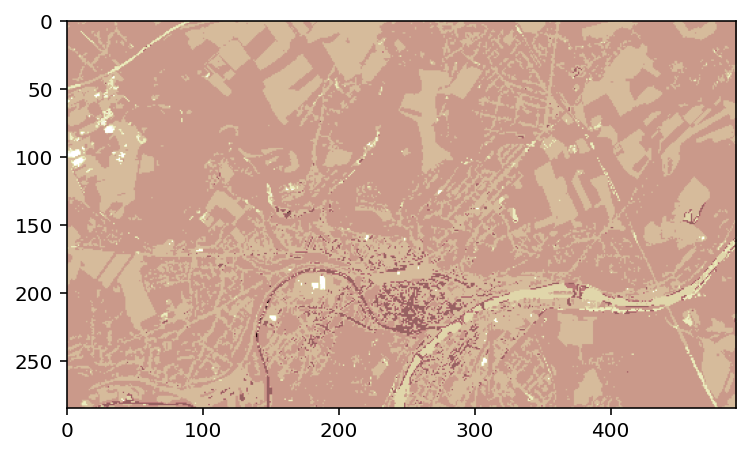

In [15]:
# Create new folder to store clipped images

clip_tp1_path = f'{output_path}CLIP_TP1/'

if not os.path.exists(clip_tp1_path):
    print(f'Create a directory to store my ROI : {clip_tp1_path}')
    os.makedirs(clip_tp1_path)

# Sentinel-2 L2A images for tile 31UFS and date 31/07/2020

L2A_path = f'{raster_path}TP_1/S2B_MSIL2A_20200731T103629_N0214_R008_T31UFS_20200731T140558.SAFE/GRANULE/L2A_T31UFS_A017766_20200731T104607/IMG_DATA/'

band_nb = '08'

img_file = f'{L2A_path}R10m/T31UFS_20200731T103629_B{band_nb}_10m.jp2'

msk_file = f'{L2A_path}R20m/T31UFS_20200731T103629_SCL_20m.jp2'


#src_file = img_file
src_file = msk_file

filename = os.path.basename(src_file)[:-4]
dst_file = f'{clip_tp1_path}{filename}_ROI.tif'


roi = gpd.read_file(roi_file)

src = rasterio.open(src_file, "r", driver='JP2OpenJPEG')

out_image, out_transform = rasterio.mask.mask(src, roi.geometry, crop=True)
out_meta = src.meta

#print(f'Metadata BEFORE : \n {out_meta}')
print(f'Width ori  : {src.width}')
print(f'Height ori : {src.height}')


# Update metadata to clip image
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

#print(f'Metadata AFTER : \n {out_meta}')

#plt.imshow(src.read(1), cmap='pink')
#plt.show()

print('----------------------')

# Write clipped image

dst = rasterio.open(dst_file, "w", **out_meta)
dst.write(out_image)

print(f'Width clipped  : {dst.width}')
print(f'Height clipped : {dst.height}')

# Close source and destination objects

src.close()
dst.close()

print('----------------------')

print(f'A new raster file is created : {dst_file}')

# Open clipped image to diplay it on Jupyter Notebook

dst = rasterio.open(dst_file, "r")
plt.imshow(dst.read(1), cmap='pink')
dst.close()


## Resample Cloud Mask

In [21]:
# Resampling parameters

upscale_factor = 2
method = 'cubic'

if method == 'nearest':
    resampling_method = Resampling.nearest
elif method == 'bilinear':
    resampling_method = Resampling.bilinear
elif method == 'cubic':
    resampling_method = Resampling.cubic

# Filenames

msk_roi_file = f'{clip_tp1_path}T31UFS_20200731T103629_SCL_20m_ROI.tif'
msk_roi_10m_file = f'{msk_roi_file[:-11]}10m_{method}_ROI.tif'

src_file = msk_roi_file
dst_file = msk_roi_10m_file

src = rasterio.open(src_file, "r", driver='GTiff')

profile = src.profile
width   = src.width*upscale_factor
height  = src.height*upscale_factor

# resample data to target shape
data = src.read(
    out_shape=(
        src.count,
        int(src.height * upscale_factor),
        int(src.width * upscale_factor)
    ),
    resampling=resampling_method
)

#print(profile)
print(f'Width ori  : {src.width}')
print(f'Height ori : {src.height}')
print('----------------------')

# scale image transform
transform = src.transform * src.transform.scale(
    (src.width / data.shape[-1]),
    (src.height / data.shape[-2])
)

profile.update(transform=transform, width=width, height=height)


# Write resampled image

dst = rasterio.open(dst_file, "w", **profile)
dst.write(data)

print(f'Width resampled  : {dst.width}')
print(f'Height resampled : {dst.height}')


# Close source and destination objects

src.close()
dst.close()

print('----------------------')

print(f'A new raster file is created : {msk_roi_10m_file}')


Width ori  : 493
Height ori : 285
----------------------
Width resampled  : 986
Height resampled : 570
----------------------
A new raster file is created : X:/GROUP_X/TP/ndeffense/DATA/CLIP_TP1/T31UFS_20200731T103629_SCL_10m_cubic_ROI.tif


## Apply Cloud Mask

Reflectance Values :
[[ 405  459  506 ...  579  504  520]
 [ 464  390  424 ...  497  484  465]
 [ 456  375  327 ...  467  398  330]
 ...
 [ 211  206  212 ... 1076 1014  972]
 [ 222  222  221 ... 1064 1023  985]
 [   0    0    0 ...    0    0    0]]
Scene Classification Values :
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 5 5 5]
 [4 4 4 ... 5 5 5]
 [4 4 4 ... 5 5 5]]


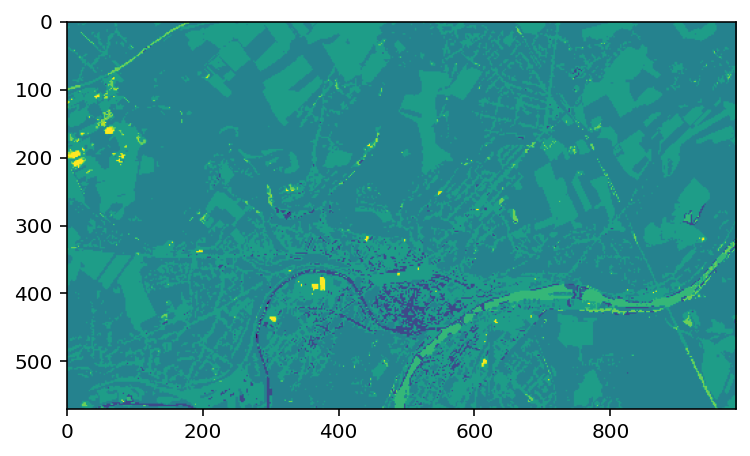

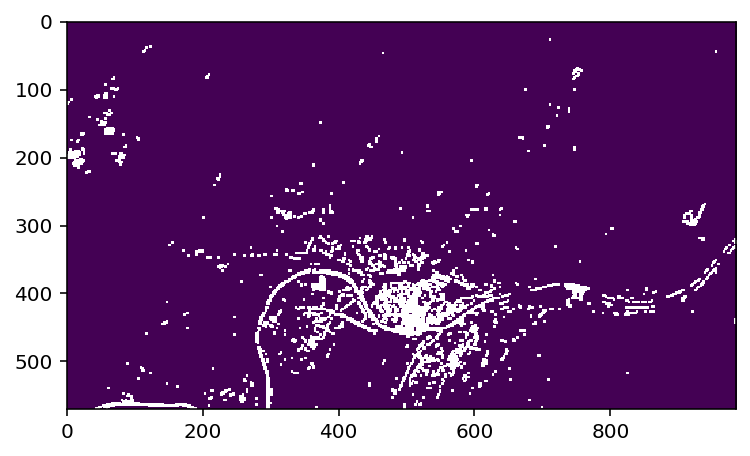

[[ 405.  459.  506. ...  579.  504.  520.]
 [ 464.  390.  424. ...  497.  484.  465.]
 [ 456.  375.  327. ...  467.  398.  330.]
 ...
 [ 211.  206.  212. ... 1076. 1014.  972.]
 [ 222.  222.  221. ... 1064. 1023.  985.]
 [   0.    0.    0. ...    0.    0.    0.]]


In [61]:

img_file = f'{clip_tp1_path}T31UFS_20200731T103629_B02_10m_ROI.tif'
msk_file = f'{clip_tp1_path}T31UFS_20200731T103629_SCL_10m_ROI.tif'

im_cm_file = f'{clip_tp1_path}T31UFS_20200731T103629_B02_10m_ROI_CM.tif'

nodata_val = -10000


src = rasterio.open(img_file, "r")
im = src.read(1)
profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
               count=1,               # We will write 1 band
               nodata=nodata_val,     # Set nodata value in metadata
               compress='lzw',        # Compression option
               driver='GTiff')
src.close()

src = rasterio.open(msk_file, "r")
CM = src.read(1)
src.close()

print('Reflectance Values :')
print(im)
print('Scene Classification Values :')
print(CM)


CM = CM.astype(float)

show(CM)


CM[CM == 0] = np.nan    # No data
CM[CM == 1] = np.nan    # Saturated or defective
CM[CM == 2] = np.nan    # Dark area pixels
CM[CM == 3] = np.nan    # Cloud shadows
CM[CM == 4] = 1         # Vegetation
CM[CM == 5] = 1         # Not vegetated
CM[CM == 6] = 1         # Water
CM[CM == 7] = 1         # Unclassified
CM[CM == 8] = np.nan    # Cloud medium probability
CM[CM == 9] = np.nan    # Cloud high probability
CM[CM == 10] = np.nan   # Thin cirrus
CM[CM == 11] = np.nan   # Snow

show(CM)


im_CM = im*CM
im_CM[np.isnan(im_CM)] = nodata_val

print(im_CM)

im_CM = im_CM.astype(np.int16)


dst = rasterio.open(im_cm_file, 'w', **profile)
dst.write(im_CM, 1)
dst.close()

## Create simple RGB composite

Transformation affine:
| 10.00, 0.00, 627260.00|
| 0.00,-10.00, 5596180.00|
| 0.00, 0.00, 1.00|
Width: 986
Height: 570


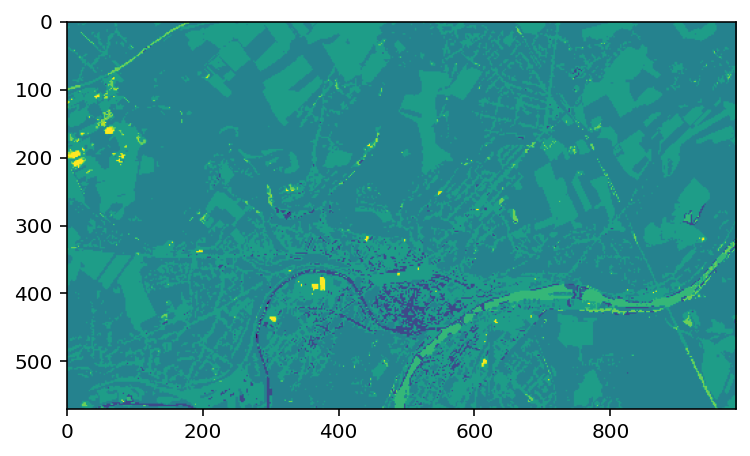

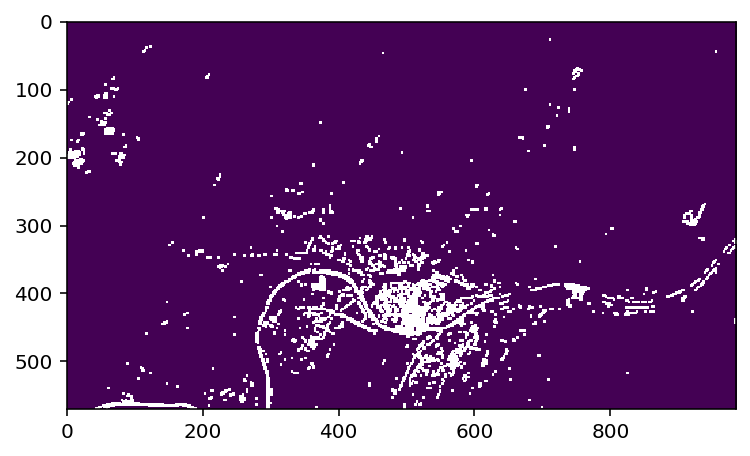

In [22]:
# Create new folder to store composites images

composite_path = f'{output_path}COMPOSITE/'

if not os.path.exists(composite_path):
    print(f'Create a directory to store my ROI : {composite_path}')
    os.makedirs(composite_path)

    
# Set path/filename to the output

TrueColor_with_CM     = f'{composite_path}TrueColor_with_CloudMask.tif'
TrueColor_without_CM  = f'{composite_path}TrueColor_without_CloudMask.tif'
FalseColor_without_CM = f'{composite_path}FalseColor_without_CloudMask.tif'

B02_roi_file = f'{clip_tp1_path}T31UFS_20200731T103629_B02_10m_ROI.tif'
B03_roi_file = f'{clip_tp1_path}T31UFS_20200731T103629_B03_10m_ROI.tif'
B04_roi_file = f'{clip_tp1_path}T31UFS_20200731T103629_B04_10m_ROI.tif'
B08_roi_file = f'{clip_tp1_path}T31UFS_20200731T103629_B08_10m_ROI.tif'

msk_roi_10m_file = f'{clip_tp1_path}T31UFS_20200731T103629_SCL_10m_ROI.tif'



# Set value for no-data (e.g. clouds, shadows,...)

nodata_val = -10000

# Open GeoTiff into rasterio object and then read into numpy array

with rasterio.open(B02_roi_file, 'r') as src:
    B2 = src.read(1)

with rasterio.open(B03_roi_file, 'r') as src:
    B3 = src.read(1)

with rasterio.open(B04_roi_file, 'r') as src:
    B4 = src.read(1)

with rasterio.open(B08_roi_file, 'r') as src:
    B8 = src.read(1)

with rasterio.open(msk_roi_10m_file, 'r') as src:
    CM = src.read(1)
    
    # Get metadata

    transf = src.transform
    width  = src.width
    height = src.height

    print(f'Transformation affine:')
    print(transf)
    print(f'Width: {width}')
    print(f'Height: {height}')
    
    # Update profile informations

    profile = src.profile

    profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
                   count=3,               # We will write 3 bands
                   nodata=nodata_val,     # Set nodata value in metadata
                   compress='lzw',        # Compression option
                   driver='GTiff')


# Apply mask on array

CM = CM.astype(float)

show(CM)

CM[CM == 0] = np.nan    # No data
CM[CM == 1] = np.nan    # Saturated or defective
CM[CM == 2] = np.nan    # Dark area pixels
CM[CM == 3] = np.nan    # Cloud shadows
CM[CM == 4] = 1         # Vegetation
CM[CM == 5] = 1         # Not vegetated
CM[CM == 6] = 1         # Water
CM[CM == 7] = 1         # Unclassified
CM[CM == 8] = np.nan    # Cloud medium probability
CM[CM == 9] = np.nan    # Cloud high probability
CM[CM == 10] = np.nan   # Thin cirrus
CM[CM == 11] = np.nan   # Snow

show(CM)


B2_CM = B2*CM
B2_CM[np.isnan(B2_CM)] = nodata_val
B3_CM = B3*CM
B3_CM[np.isnan(B3_CM)] = nodata_val
B4_CM = B4*CM
B4_CM[np.isnan(B4_CM)] = nodata_val
B8_CM = B8*CM
B8_CM[np.isnan(B8_CM)] = nodata_val

# Convert all spectral bands from float to integer 16

B2 = B2.astype(np.int16)
B3 = B3.astype(np.int16)
B4 = B4.astype(np.int16)
B8 = B8.astype(np.int16)

B2_CM = B2_CM.astype(np.int16)
B3_CM = B3_CM.astype(np.int16)
B4_CM = B4_CM.astype(np.int16)
B8_CM = B8_CM.astype(np.int16)


# Write composites images

with rasterio.open(FalseColor_without_CM, 'w', **profile) as dst:
    dst.write(B8, 1)
    dst.write(B4, 2)
    dst.write(B3, 3)
    
with rasterio.open(TrueColor_without_CM, 'w', **profile) as dst:
    dst.write(B4, 1)
    dst.write(B3, 2)
    dst.write(B2, 3)

with rasterio.open(TrueColor_with_CM, 'w', **profile) as dst:
    dst.write(B4_CM, 1)
    dst.write(B3_CM, 2)
    dst.write(B2_CM, 3)



## Compute NDVI
- NDVI = (NIR - RED) / (NIR + RED)
- NDVI = (B8 - B4) / (B8 + B4)

In [41]:
np.seterr(divide='ignore', invalid='ignore')

NDVI_file = f'{output_path}NDVI.tif'


# Open RED band and update metadata

src = rasterio.open(B04_roi_file, 'r')

profile = src.profile
profile.update(dtype=rasterio.int16,  # Set to float
               compress='lzw')          # Compression option

B4 = src.read(1)
src.close()

# Open NIR band

src = rasterio.open(B08_roi_file, 'r')
B8 = src.read(1)
src.close()


# Compute NDVI

NDVI = (B8 - B4) / (B8 + B4) * 1000
NDVI = NDVI.astype(np.int16)

# Write NDVI image

dst = rasterio.open(NDVI_file, "w", **profile)
dst.write(NDVI,1)
dst.close()

print('----------------------')

print(f'A new raster file is created : {NDVI_file}')
    

----------------------
A new raster file is created : X:/GROUP_X/TP/ndeffense/DATA/NDVI.tif


## Open shapefile

In [28]:
parcels_shp = f'{vector_path}TP_2/WALLONIA_2018_In_Situ_v1.shp'

# Open parcels shapefile as a new GeoDataFrame

parcels_gdf = gpd.read_file(parcels_shp)


# Get the number of parcels

print(f'There are {len(parcels_gdf)} parcels in the entire shapefile')


# Plot a given parcel --> one package is missing !

crops_901 = parcels_gdf.loc[parcels_gdf['CODE']==901]
#crops_901.plot()

There are 2853 parcels in the shapefile


## Select polygons inside the ROI

In [36]:
# Create new folder to store composites images

myVector_path = f'{output_path}VECTOR/'

if not os.path.exists(myVector_path):
    print(f'Create a directory to store my ROI : {myVector_path}')
    os.makedirs(myVector_path)


# Open ROI as GeoDataFrame

roi_gdf = gpd.read_file(roi_file)

# Check if Coordinates Reference System are the same

print(f'ROI CRS     : {roi_gdf.crs}')
print(f'PARCELS CRS : {parcels_gdf.crs}')

# Select parcels inside the ROI

parcels_roi_gdf = parcels_gdf[parcels_gdf.within(roi_gdf.geometry[0])]


print(f'There are {len(parcels_roi_gdf)} parcels in the ROI')

# Write subset parcels in a new shapefile

parcels_roi_gdf.to_file(f'{myVector_path}parcels_ROI.shp')


Create a directory to store my ROI : X:/GROUP_X/TP/ndeffense/DATA/VECTOR/
ROI CRS     : epsg:32631
PARCELS CRS : epsg:32631
There are 111 parcels in the ROI


## Zonal statictis with "rasterstat" library : quick recap

In [48]:
# Select a parcel in the ROI

ZStat_vector = parcels_roi_gdf.loc[parcels_roi_gdf['ID']==4552]


# Zonal Stats from GeoTIFF file

ZS_1 = pd.DataFrame(
            zonal_stats(vectors=ZStat_vector['geometry'],
                        raster=NDVI_file,
                        layer=0,
                        band_num=1,
                        nodata=np.nan,
                        stats='mean'))


# Zonal Stats from Numpy Array

with rasterio.open(NDVI_file, 'r') as src:
    NDVI_array = src.read(1)


ZS_2 = pd.DataFrame(
            zonal_stats(vectors=ZStat_vector['geometry'],
                        raster=NDVI_array,
                        affine=transf,         # Must set the affine transformation !
                        nodata=np.nan,         # Must set the nodata values !
                        stats='mean'))


# Check if both methods give the same results


if ZS_1['mean'].values[0] == ZS_2['mean'].values[0]:
    print(f'Both results are similar : {round(ZS_1["mean"].values[0],2)} = {round(ZS_2["mean"].values[0],2)}')

else:
    print(f'{round(ZS_1["mean"].values[0],2)} != {round(ZS_2["mean"].values[0],2)}')



Both results are similar : 233.25 = 233.25


## Dealing with timeseries
    Create a DataFrame with Pandas to store all informations at the same place.

In [ ]:
df_CM = df.loc[df['band'] == '0'].reset_index()
#df_B2 = df.loc[df['band'] == '2'].reset_index()
#df_B3 = df.loc[df['band'] == '3'].reset_index()
df_B4 = df.loc[df['band'] == '4'].reset_index()
df_B8 = df.loc[df['band'] == '8'].reset_index()


date_list  = []
B2_ts_list = []
B3_ts_list = []
B4_ts_list = []
B8_ts_list = []


#for i in range(0,len(df_ma)):
for i in range(0,20):

    date  = df_CM.loc[i,['date']][0]
    print(f'{i} -  Add date {date}')
    
    CM_path = df_CM.loc[i,['im_path']][0]
    #B2_path = df_B2.loc[i,['im_path']][0]
    #B3_path = df_B3.loc[i,['im_path']][0]
    B4_path = df_B4.loc[i,['im_path']][0]
    B8_path = df_B8.loc[i,['im_path']][0]
    
    CM_src = rasterio.open(CM_path)
    #B2_src = rasterio.open(B2_path)
    #B3_src = rasterio.open(B3_path)
    B4_src = rasterio.open(B4_path)
    B8_src = rasterio.open(B8_path)

    
    CM = CM_src.read(1)
    CM = np.where(CM==0, 1, np.nan)
    
    #B2 = B2_src.read(1)
    #B3 = B3_src.read(1)
    B4 = B4_src.read(1)
    B8 = B8_src.read(1)
    
    #B2_CM = B2*CM  
    #B3_CM = B3*CM
    B4_CM = B4*CM
    B8_CM = B8*CM
    
    date_list.append(date)
    #B2_ts_list.append(B2_CM)
    #B3_ts_list.append(B3_CM)
    B4_ts_list.append(B4_CM)
    B8_ts_list.append(B8_CM)
    
    CM_src.close()
    #B2_src.close()
    #B3_src.close()
    B4_src.close()
    B8_src.close()

date  = np.concatenate([date_list]) 
#B2_ts = np.concatenate([B2_ts_list])
#B3_ts = np.concatenate([B3_ts_list])
B4_ts = np.concatenate([B4_ts_list])
B8_ts = np.concatenate([B8_ts_list])


print(B4_ts.shape)
print(B8_ts.shape)
print(np.info(B4_ts))